In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import glob 
import keras
import pathlib
import tensorflow as tf
import tensorflow_addons as tfa
import skimage.color as scc

from skimage import io
from random import randint
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ID
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional

In [46]:
conda install keras

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.



EnvironmentLocationNotFound: Not a conda environment: C:\Users\Sriya



In [134]:
pip install np_utils

     ---------------------------------------- 62.0/62.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56454 sha256=93e3ed86a17c61397616d22db8edebcb7a0d1e901588f9333a9a250742ef5c5e
  Stored in directory: c:\users\sriya nukala\appdata\local\pip\cache\wheels\c9\5e\52\216e2fa9b02d46b865d8160e7fe29dcf98f89a2fb7be254877
Successfully built np_utils
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install tensorflow

     -------------------------------------- 284.1/284.1 MB 2.9 MB/s eta 0:00:00
     -------------------------------------- 440.7/440.7 kB 6.8 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 24.4/24.4 MB 3.7 MB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 4.0 MB/s eta 0:00:00
     -------------------------------------- 130.2/130.2 kB 3.9 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 4.7 MB/s eta 0:00:00
     -------------------------------------- 938.6/938.6 kB 5.4 MB/s eta 0:00:00
     ---------------------------------------- 3.7/3.7 MB 4.2 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 4.9 MB/s eta 0:00:00
     ------------------------------------- 182.0/182.0 kB 10.7 MB/s eta 0:00:00
     -------------------------------------- 151.

In [1]:
pip install tensorflow_addons

     -------------------------------------- 719.8/719.8 kB 4.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [3]:
dataset_path = r'C:\Users\USER\Downloads\Dataset\gaussian_filtered_images'
filepaths=[]
labels=[]

In [4]:
folds = os.listdir(dataset_path)

In [5]:
folds

['export.pkl', 'Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

In [6]:
for fold in folds:
    foldpath = os.path.join(dataset_path, fold)  
    # skip export.pkl file
    if pathlib.Path(foldpath).suffix == '':
        filelist = os.listdir(foldpath)

        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

In [7]:
img_paths = pd.Series(filepaths, name= 'filepaths')
img_labels = pd.Series(labels, name='labels')
dataset = pd.concat([img_paths, img_labels], axis= 1)

In [8]:
dataset

filepaths  labels
0     C:\Users\USER\Downloads\Dataset\gaussian_filte...    Mild
1     C:\Users\USER\Downloads\Dataset\gaussian_filte...    Mild
2     C:\Users\USER\Downloads\Dataset\gaussian_filte...    Mild
3     C:\Users\USER\Downloads\Dataset\gaussian_filte...    Mild
4     C:\Users\USER\Downloads\Dataset\gaussian_filte...    Mild
...                                                 ...     ...
3657  C:\Users\USER\Downloads\Dataset\gaussian_filte...  Severe
3658  C:\Users\USER\Downloads\Dataset\gaussian_filte...  Severe
3659  C:\Users\USER\Downloads\Dataset\gaussian_filte...  Severe
3660  C:\Users\USER\Downloads\Dataset\gaussian_filte...  Severe
3661  C:\Users\USER\Downloads\Dataset\gaussian_filte...  Severe

[3662 rows x 2 columns]

In [9]:
batch_size=3662
img=224
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

gen=ID()
data_gen = gen.flow_from_dataframe( dataset,x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)


Found 3662 validated image filenames belonging to 5 classes.


In [10]:
img_data, img_labels = data_gen.next()

In [11]:
print(img_data.shape, img_labels.shape)

(3662, 224, 224, 3) (3662, 5)


In [12]:
img_labels

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

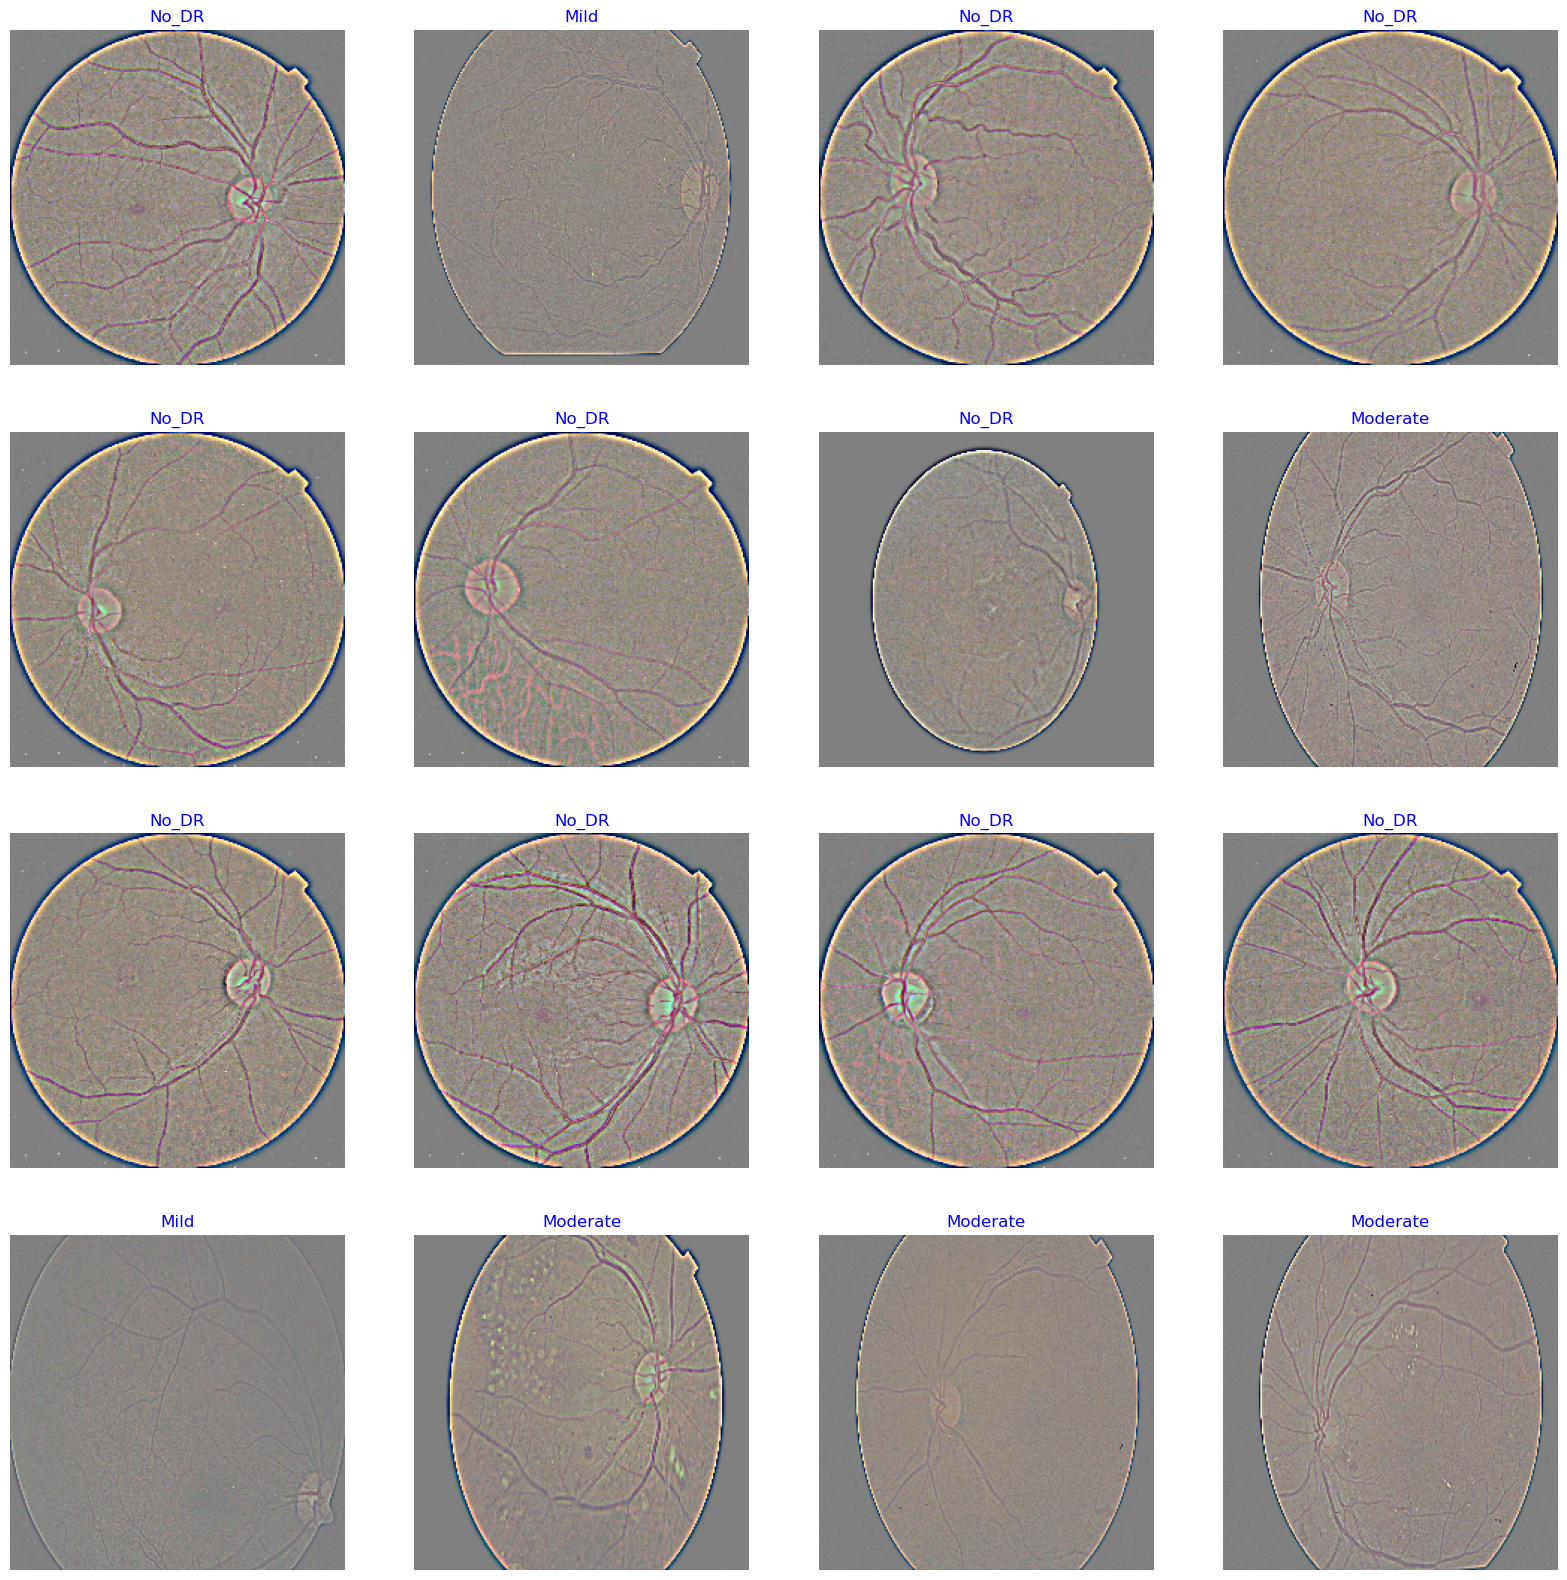

In [13]:
g_dict = data_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(data_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [20]:
train_data, test_data, train_labels, test_labels = train_test_split(img_data, img_labels, test_size = 0.25, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [21]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from keras import Input,Model
from keras.layers import BatchNormalization,LSTM,TimeDistributed

In [34]:
enetb3 = EfficientNetB3(input_shape = (224,224,3), weights = 'imagenet', include_top = False)
for layer in enetb3.layers:
    layer.trainable = False

# x = TimeDistributed(LSTM(32,activation="sigmoid",return_sequences=False))(enetb3.output)
# x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(enetb3.output)
# x = BatchNormalization()(enetb3.output)
# x = Conv2D(64, kernel_size=(5,5),activation='relu')(enetb3.output)
x = Flatten()(x)
x = Dense(128, activation = 'relu',kernel_regularizer=regularizers.l2(0.01))(x) 
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation = 'softmax')(x) 
model = Model(inputs = enetb3.input, outputs = x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

In [35]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_16 (Rescaling)    (None, 224, 224, 3)          0         ['input_9[0][0]']             
                                                                                                  
 normalization_8 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_16[0][0]']        
 tion)                                                                                            
                                                                                                  
 rescaling_17 (Rescaling)    (None, 224, 224, 3)          0         ['normalization_8[0][0]'

                                                                                                  
 block2a_expand_conv (Conv2  (None, 112, 112, 144)        3456      ['block1b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block2a_expand_bn (BatchNo  (None, 112, 112, 144)        576       ['block2a_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block2a_expand_activation   (None, 112, 112, 144)        0         ['block2a_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block2a_d

 block2c_expand_conv (Conv2  (None, 56, 56, 192)          6144      ['block2b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block2c_expand_bn (BatchNo  (None, 56, 56, 192)          768       ['block2c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block2c_expand_activation   (None, 56, 56, 192)          0         ['block2c_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block2c_dwconv (DepthwiseC  (None, 56, 56, 192)          1728      ['block2c_expand_activation[0]
 onv2D)   

 D)                                                                                               
                                                                                                  
 block3b_expand_bn (BatchNo  (None, 28, 28, 288)          1152      ['block3b_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block3b_expand_activation   (None, 28, 28, 288)          0         ['block3b_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block3b_dwconv (DepthwiseC  (None, 28, 28, 288)          7200      ['block3b_expand_activation[0]
 onv2D)                                                             [0]']                         
          

 block4a_expand_conv (Conv2  (None, 28, 28, 288)          13824     ['block3c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block4a_expand_bn (BatchNo  (None, 28, 28, 288)          1152      ['block4a_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block4a_expand_activation   (None, 28, 28, 288)          0         ['block4a_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block4a_dwconv_pad (ZeroPa  (None, 29, 29, 288)          0         ['block4a_expand_activation[0]
 dding2D) 

 D)                                                                                               
                                                                                                  
 block4c_expand_bn (BatchNo  (None, 14, 14, 576)          2304      ['block4c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block4c_expand_activation   (None, 14, 14, 576)          0         ['block4c_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block4c_dwconv (DepthwiseC  (None, 14, 14, 576)          5184      ['block4c_expand_activation[0]
 onv2D)                                                             [0]']                         
          

 block4e_expand_conv (Conv2  (None, 14, 14, 576)          55296     ['block4d_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block4e_expand_bn (BatchNo  (None, 14, 14, 576)          2304      ['block4e_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block4e_expand_activation   (None, 14, 14, 576)          0         ['block4e_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block4e_dwconv (DepthwiseC  (None, 14, 14, 576)          5184      ['block4e_expand_activation[0]
 onv2D)   

 rmalization)                                                                                     
                                                                                                  
 block5b_expand_activation   (None, 14, 14, 816)          0         ['block5b_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block5b_dwconv (DepthwiseC  (None, 14, 14, 816)          20400     ['block5b_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block5b_bn (BatchNormaliza  (None, 14, 14, 816)          3264      ['block5b_dwconv[0][0]']      
 tion)                                                                                            
          

 block5d_expand_bn (BatchNo  (None, 14, 14, 816)          3264      ['block5d_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block5d_expand_activation   (None, 14, 14, 816)          0         ['block5d_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block5d_dwconv (DepthwiseC  (None, 14, 14, 816)          20400     ['block5d_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block5d_bn (BatchNormaliza  (None, 14, 14, 816)          3264      ['block5d_dwconv[0][0]']      
 tion)    

                                                                                                  
 block6a_expand_bn (BatchNo  (None, 14, 14, 816)          3264      ['block6a_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6a_expand_activation   (None, 14, 14, 816)          0         ['block6a_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block6a_dwconv_pad (ZeroPa  (None, 17, 17, 816)          0         ['block6a_expand_activation[0]
 dding2D)                                                           [0]']                         
                                                                                                  
 block6a_d

 block6c_expand_bn (BatchNo  (None, 7, 7, 1392)           5568      ['block6c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6c_expand_activation   (None, 7, 7, 1392)           0         ['block6c_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block6c_dwconv (DepthwiseC  (None, 7, 7, 1392)           34800     ['block6c_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block6c_bn (BatchNormaliza  (None, 7, 7, 1392)           5568      ['block6c_dwconv[0][0]']      
 tion)    

                                                                                                  
 block6e_expand_bn (BatchNo  (None, 7, 7, 1392)           5568      ['block6e_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6e_expand_activation   (None, 7, 7, 1392)           0         ['block6e_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block6e_dwconv (DepthwiseC  (None, 7, 7, 1392)           34800     ['block6e_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block6e_b

 D)                                                                                               
                                                                                                  
 block7a_expand_bn (BatchNo  (None, 7, 7, 1392)           5568      ['block7a_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block7a_expand_activation   (None, 7, 7, 1392)           0         ['block7a_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block7a_dwconv (DepthwiseC  (None, 7, 7, 1392)           12528     ['block7a_expand_activation[0]
 onv2D)                                                             [0]']                         
          

 top_activation (Activation  (None, 7, 7, 1536)           0         ['top_bn[0][0]']              
 )                                                                                                
                                                                                                  
 global_average_pooling2d_8  (None, 1536)                 0         ['top_activation[0][0]']      
  (GlobalAveragePooling2D)                                                                        
                                                                                                  
 flatten_3 (Flatten)         (None, 1536)                 0         ['global_average_pooling2d_8[0
                                                                    ][0]']                        
                                                                                                  
 dense_9 (Dense)             (None, 128)                  196736    ['flatten_3[0][0]']           
          

In [28]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
           tf.keras.metrics.AUC(name='AUC'),
           tfa.metrics.F1Score(num_classes=5)]

In [36]:
history = model.fit(train_data,train_labels, epochs= 35,verbose= 1, validation_data= (val_data,val_labels), 
                    validation_steps= None, shuffle= False,batch_size=32)

Epoch 1/35
69/69 [==============================] - 559s 8s/step - loss: 2.2825 - Accuracy: 0.6676 - AUC: 0.8874 - f1_score: 0.3459 - val_loss: 1.3491 - val_Accuracy: 0.7527 - val_AUC: 0.9449 - val_f1_score: 0.3345
Epoch 2/35
69/69 [==============================] - 436s 6s/step - loss: 1.2425 - Accuracy: 0.7168 - AUC: 0.9225 - f1_score: 0.4119 - val_loss: 0.9685 - val_Accuracy: 0.7655 - val_AUC: 0.9460 - val_f1_score: 0.3727
Epoch 3/35
69/69 [==============================] - 441s 6s/step - loss: 1.0005 - Accuracy: 0.7145 - AUC: 0.9275 - f1_score: 0.4021 - val_loss: 0.8282 - val_Accuracy: 0.7691 - val_AUC: 0.9516 - val_f1_score: 0.3759
Epoch 4/35
69/69 [==============================] - 427s 6s/step - loss: 0.9156 - Accuracy: 0.7318 - AUC: 0.9288 - f1_score: 0.3859 - val_loss: 0.7700 - val_Accuracy: 0.7618 - val_AUC: 0.9512 - val_f1_score: 0.3443
Epoch 5/35
69/69 [==============================] - 412s 6s/step - loss: 0.8330 - Accuracy: 0.7418 - AUC: 0.9368 - f1_score: 0.3970 - val_lo

In [37]:
train_scores = model.evaluate(train_data, train_labels)
val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data,test_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

29/29 [==============================] - 157s 5s/step - loss: 0.6816 - Accuracy: 0.7675 - AUC: 0.9541 - f1_score: 0.4688
Training Accuracy: 79.14%
Validation Accuracy: 79.45%
Testing Accuracy: 76.75%


In [14]:
pre_trained_model = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet')

In [15]:
pre_trained_model.trainable = False

In [41]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape

In [42]:
input_shape = (224,224,3)
# Add a new Conv2D layer to the pre-trained model
layer1 = Conv2D(64, kernel_size=(3,3),padding='same',activation='relu',strides=(1,1))(pre_trained_model.output)
layer2 = Conv2D(64, kernel_size=(3,3),padding='same',activation='relu',strides=(1,1))(layer1)
layer3 = Conv2D(128, kernel_size=(3,3),padding='same',activation='relu',strides=(1,1))(layer2)
layer4 = Conv2D(128, kernel_size=(3,3),padding='same',activation='relu',strides=(1,1))(layer3)
poollayer1=MaxPooling2D()(layer4)
flayer=Flatten()(poollayer1)
reshaped_layer = Reshape((1, -1))(flayer)
# Add a new dense layer to the pre-trained model
dense1 = Dense(32, activation='relu')(reshaped_layer)
dense2 = Dense(16, activation='relu')(dense1)
dense3 = Dense(5, activation='softmax')(dense2)

# Create a new model
model = Model(inputs=pre_trained_model.input, outputs=dense3)
model.summary()
# Compile the model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train the model
# model.fit(train_data, train_labels, epochs=10)

ValueError: The last dimension of the inputs to a Dense layer should be defined. Found None. Full input shape received: (None, 1, None)

In [20]:
# class MyCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if logs.get('val_acc') >= 0.99:
#             print("\nReached accuracy threshold! Terminating training.")
#             self.model.stop_training = True
            
# my_callback = MyCallback()

# #EarlyStopping callback to make sure model is always learning
# early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [21]:
# CALLBACKS = [my_callback]

In [35]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
           tf.keras.metrics.AUC(name='AUC'),
           tfa.metrics.F1Score(num_classes=5)]

In [31]:
# from keras.optimizers import SGD
# opt = SGD(lr=0.01)

In [36]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

In [37]:
history = model.fit(train_data,train_labels, epochs= 10,verbose= 1, validation_data= (val_data,val_labels), 
                    validation_steps= None, shuffle= False,batch_size=32)

Epoch 1/10


ValueError: in user code:

    File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1127, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1185, in compute_loss
        return self.compiled_loss(
    File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\backend.py", line 5575, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 5) and (None, 3, 3, 5) are incompatible


In [26]:
train_scores = model.evaluate(train_data, train_labels)
val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data,test_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

29/29 [==============================] - 133s 5s/step - loss: 1.2549 - Accuracy: 0.6889 - AUC: 0.8880 - f1_score: 0.4603
Training Accuracy: 94.13%
Validation Accuracy: 69.82%
Testing Accuracy: 68.89%


In [17]:
train_data2.shape

(5440, 224, 224, 3)

In [15]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model

In [16]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
           tf.keras.metrics.AUC(name='AUC'),
           tfa.metrics.F1Score(num_classes=5)]

In [17]:
dnet121 = DenseNet121(input_shape = (224,224,3), weights = 'imagenet', include_top = False)
for layer in dnet121.layers:
    layer.trainable = False
x = Flatten()(dnet121.output)
x = Dense(128, activation = 'relu')(x) 
x = Dense(64, activation = 'relu')(x) 
x = Dense(5, activation = 'softmax')(x) 
model = Model(inputs = dnet121.input, outputs = x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

29084464/29084464 [==============================] - 8s 0us/step


In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

 conv2_block4_0_bn (BatchNo  (None, 56, 56, 160)          640       ['conv2_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block4_0_relu (Activ  (None, 56, 56, 160)          0         ['conv2_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block4_1_conv (Conv2  (None, 56, 56, 128)          20480     ['conv2_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block4_1_bn (BatchNo  (None, 56, 56, 128)          512       ['conv2_block4_1_conv[0][0]'] 
 rmalizati

 rmalization)                                                                                     
                                                                                                  
 conv3_block1_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block1_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block1_concat (Conca  (None, 28, 28, 160)          0         ['pool2_pool[0][0]',          
 tenate)                                                             'conv3_block1_2_conv[0][0]'] 
          

 conv3_block5_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block5_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block5_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block5_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block5_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block5_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block5_concat (Conca  (None, 28, 28, 288)          0         ['conv3_block4_concat[0][0]', 
 tenate)  

                                                                                                  
 conv3_block9_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block9_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block9_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block9_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_blo

 pool3_pool (AveragePooling  (None, 14, 14, 256)          0         ['pool3_conv[0][0]']          
 2D)                                                                                              
                                                                                                  
 conv4_block1_0_bn (BatchNo  (None, 14, 14, 256)          1024      ['pool3_pool[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_0_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_1_conv (Conv2  (None, 14, 14, 128)          32768     ['conv4_block1_0_relu[0][0]'] 
 D)       

                                                                                                  
 conv4_block4_concat (Conca  (None, 14, 14, 384)          0         ['conv4_block3_concat[0][0]', 
 tenate)                                                             'conv4_block4_2_conv[0][0]'] 
                                                                                                  
 conv4_block5_0_bn (BatchNo  (None, 14, 14, 384)          1536      ['conv4_block4_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block5_0_relu (Activ  (None, 14, 14, 384)          0         ['conv4_block5_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block8_concat (Conca  (None, 14, 14, 512)          0         ['conv4_block7_concat[0][0]', 
 tenate)                                                             'conv4_block8_2_conv[0][0]'] 
                                                                                                  
 conv4_block9_0_bn (BatchNo  (None, 14, 14, 512)          2048      ['conv4_block8_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_0_relu (Activ  (None, 14, 14, 512)          0         ['conv4_block9_0_bn[0][0]']   
 ation)                                                                                           
          

 conv4_block12_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block12_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block12_concat (Conc  (None, 14, 14, 640)          0         ['conv4_block11_concat[0][0]',
 atenate)                                                            'conv4_block12_2_conv[0][0]']
                                                                                                  
 conv4_block13_0_bn (BatchN  (None, 14, 14, 640)          2560      ['conv4_block12_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block13_0_relu (Acti  (None, 14, 14, 640)          0         ['conv4_block13_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv4_block16_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block16_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_concat (Conc  (None, 14, 14, 768)          0         ['conv4_block15_concat[0][0]',
 atenate)                                                            'conv4_block16_2_conv[0][0]']
                                                                                                  
 conv4_block17_0_bn (BatchN  (None, 14, 14, 768)          3072      ['conv4_block16_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block20_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block20_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block20_concat (Conc  (None, 14, 14, 896)          0         ['conv4_block19_concat[0][0]',
 atenate)                                                            'conv4_block20_2_conv[0][0]']
                                                                                                  
 conv4_block21_0_bn (BatchN  (None, 14, 14, 896)          3584      ['conv4_block20_concat[0][0]']
 ormalization)                                                                                    
          

 conv4_block24_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block24_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block24_concat (Conc  (None, 14, 14, 1024)         0         ['conv4_block23_concat[0][0]',
 atenate)                                                            'conv4_block24_2_conv[0][0]']
                                                                                                  
 pool4_bn (BatchNormalizati  (None, 14, 14, 1024)         4096      ['conv4_block24_concat[0][0]']
 on)      

 rmalization)                                                                                     
                                                                                                  
 conv5_block4_0_relu (Activ  (None, 7, 7, 608)            0         ['conv5_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block4_1_conv (Conv2  (None, 7, 7, 128)            77824     ['conv5_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block4_1_bn (BatchNo  (None, 7, 7, 128)            512       ['conv5_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv5_block8_0_bn (BatchNo  (None, 7, 7, 736)            2944      ['conv5_block7_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block8_0_relu (Activ  (None, 7, 7, 736)            0         ['conv5_block8_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block8_1_conv (Conv2  (None, 7, 7, 128)            94208     ['conv5_block8_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block8_1_bn (BatchNo  (None, 7, 7, 128)            512       ['conv5_block8_1_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv5_block12_0_bn (BatchN  (None, 7, 7, 864)            3456      ['conv5_block11_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block12_0_relu (Acti  (None, 7, 7, 864)            0         ['conv5_block12_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block12_1_conv (Conv  (None, 7, 7, 128)            110592    ['conv5_block12_0_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_blo

 atenate)                                                            'conv5_block15_2_conv[0][0]']
                                                                                                  
 conv5_block16_0_bn (BatchN  (None, 7, 7, 992)            3968      ['conv5_block15_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block16_0_relu (Acti  (None, 7, 7, 992)            0         ['conv5_block16_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block16_1_conv (Conv  (None, 7, 7, 128)            126976    ['conv5_block16_0_relu[0][0]']
 2D)                                                                                              
          

In [19]:
history = model.fit(train_data,train_labels, epochs= 10,verbose= 1, validation_data= (val_data,val_labels), 
                    validation_steps= None, shuffle= False,batch_size=32)

Epoch 1/10
69/69 [==============================] - 142s 2s/step - loss: 11.5703 - Accuracy: 0.6339 - AUC: 0.8016 - f1_score: 0.4129 - val_loss: 3.3061 - val_Accuracy: 0.7545 - val_AUC: 0.8725 - val_f1_score: 0.4131
Epoch 2/10
69/69 [==============================] - 134s 2s/step - loss: 2.5809 - Accuracy: 0.7072 - AUC: 0.8745 - f1_score: 0.5241 - val_loss: 3.9682 - val_Accuracy: 0.7145 - val_AUC: 0.8638 - val_f1_score: 0.3427
Epoch 3/10
69/69 [==============================] - 132s 2s/step - loss: 3.4693 - Accuracy: 0.7158 - AUC: 0.8737 - f1_score: 0.5284 - val_loss: 3.0469 - val_Accuracy: 0.6055 - val_AUC: 0.8302 - val_f1_score: 0.4084
Epoch 4/10
69/69 [==============================] - 125s 2s/step - loss: 2.2924 - Accuracy: 0.7377 - AUC: 0.8997 - f1_score: 0.5611 - val_loss: 2.3224 - val_Accuracy: 0.6345 - val_AUC: 0.8508 - val_f1_score: 0.4399
Epoch 5/10
69/69 [==============================] - 130s 2s/step - loss: 1.3345 - Accuracy: 0.7691 - AUC: 0.9275 - f1_score: 0.6117 - val_l

In [20]:
train_scores = model.evaluate(train_data, train_labels)
val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data,test_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

29/29 [==============================] - 42s 1s/step - loss: 1.4963 - Accuracy: 0.7325 - AUC: 0.8984 - f1_score: 0.4475
Training Accuracy: 86.89%
Validation Accuracy: 79.64%
Testing Accuracy: 73.25%


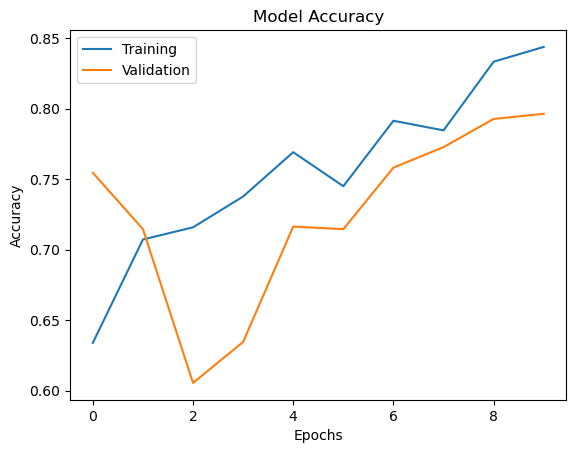

In [21]:
fig, ax = plt.subplots()
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig('Model Accuracy_dnet121_nsm_nes-10.png', format='png', dpi=300)

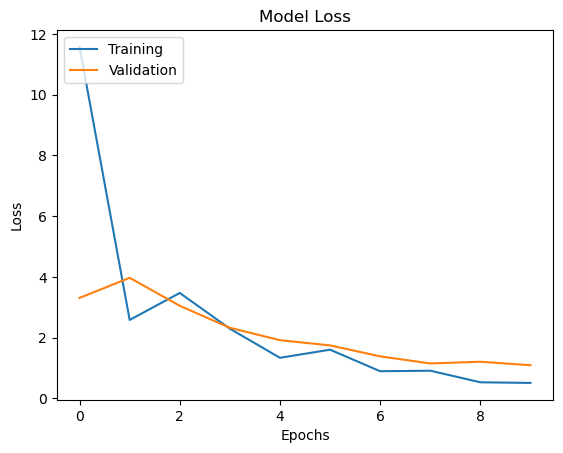

In [22]:
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig('Model Loss_dnet121_nsm_nes-10.png', format='png', dpi=300)

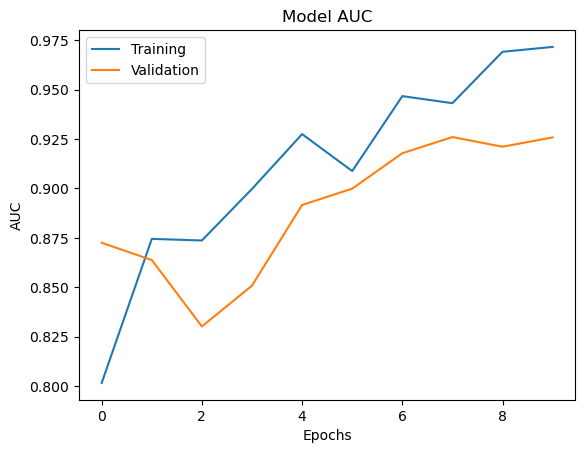

In [23]:
fig, ax = plt.subplots()
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig('Model AUC_dnet121_nsm_nes-10.png', format='png', dpi=300)

In [24]:
pred_labels = model.predict(test_data)

29/29 [==============================] - 44s 1s/step


In [25]:
from sklearn import metrics
auc = metrics.roc_auc_score(test_labels,pred_labels,multi_class='ovo')
auc

0.8499539881129211

In [34]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)
conf_arr

NameError: name 'confusion_matrix' is not defined

In [ ]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)
cmn = conf_arr.astype('float') / conf_arr.sum(axis=1)[:, np.newaxis]
fig=plt.figure(figsize=(4,3), dpi=300, facecolor='w', edgecolor='k')

ax = sns.heatmap(cmn, cmap='Greens', annot=True, fmt=".2f", xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)
ax.figure.savefig('confmatrix_VGG16.png', format='png', dpi=300)

In [ ]:
pred_labels1=np.argmax(pred_labels,axis=1)
test_labels1=np.argmax(test_labels,axis=1)

In [ ]:
predlabels_new=label_binarize(pred_labels1,classes=np.unique(pred_labels1))
classes=np.unique(pred_labels1)

In [ ]:
fig, ax = plt.subplots()
f_p_r=dict()
t_p_r = dict()
thres=dict()
rocauc_curve= dict()
total_no_of_class = classes.shape[0]
for i in range(total_no_of_class):    
    f_p_r[i], t_p_r[i], thres[i] = metrics.roc_curve(test_labels[:,i],predlabels_new[:,i])
    rocauc_curve[i] = metrics.auc(f_p_r[i], t_p_r[i])    
    plt.plot(f_p_r[i], t_p_r[i], linestyle='--',label='%s vs Rest (AUC=%0.2f)'%(classes[i],rocauc_curve[i]))

plt.plot([0,1],[0,1],'b-')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('ROC-AUC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()
fig.savefig('ROCAUC_EfficientNet.png', format='png', dpi=300)

In [ ]:
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)
print(classification_report(test_labels, pred_labels, target_names=CLASSES))

In [ ]:
fpr = dict()
tpr = dict()
thresh =dict()
roc_auc = dict()

n_class = classes.shape[0]
fig=plt.figure(figsize=(10, 8), dpi=300)
for i, in zip(range(n_class)):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(test_labels[:,i],predlabels_new[:,i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    if classes[i]==0:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='NonDemented (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==1:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='VeryMildDemented (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==2:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='MildDemented (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==3:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='ModerateDemented (AUC=%0.2f)'%(roc_auc[i]))
plt.plot([0,1],[0,1],'b-')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()
fig.savefig('myfig_EfficientNet.png',dpi=300)

In [ ]:
fpr = dict()
tpr = dict()
thresh =dict()
roc_auc = dict()

n_class = classes.shape[0]

fig=plt.figure(figsize=(10, 8), dpi=300)
for i in zip(range(n_class)):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(test_labels[:,i],pred_labels[:,i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    if classes[i]==0:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='NonDemented (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==1:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='VeryMildDemented (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==2:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='MildDemented (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==3:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='ModerateDemented (AUC=%0.2f)'%(roc_auc[i]))
plt.plot([0,1],[0,1],'b-')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Testing ROC_AUC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()
fig.savefig('brain mri testing roc auc_EfficientNet.png',dpi=300)# roc curve for classes